In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
import pandas as pd
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


In [3]:
df = train.append(test).reset_index(drop=True)
print(df.shape)

(2919, 81)


In [4]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [5]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

##################### Shape #####################
(2919, 81)
##################### Types #####################
Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice        float64
Length: 81, dtype: object
##################### Head #####################
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl

In [6]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 2919
Variables: 81
cat_cols: 52
num_cols: 28
cat_but_car: 1
num_but_cat: 10


In [7]:
df["Neighborhood"].value_counts()

NAmes      443
CollgCr    267
OldTown    239
Edwards    194
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     71
StoneBr     51
SWISU       48
ClearCr     44
MeadowV     37
BrDale      30
Blmngtn     28
Veenker     24
NPkVill     23
Blueste     10
Name: Neighborhood, dtype: int64

In [8]:
# Kategorik Değişken Analizi
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

for col in cat_cols:
    cat_summary(df, col)

         MSZoning      Ratio
RL           2265  77.595067
RM            460  15.758822
FV            139   4.761905
RH             26   0.890716
C (all)        25   0.856458
##########################################
      Street    Ratio
Pave    2907  99.5889
Grvl      12   0.4111
##########################################
      Alley     Ratio
Grvl    120  4.110997
Pave     78  2.672148
##########################################
     LotShape      Ratio
Reg      1859  63.686194
IR1       968  33.162042
IR2        76   2.603631
IR3        16   0.548133
##########################################
     LandContour      Ratio
Lvl         2622  89.825283
HLS          120   4.110997
Bnk          117   4.008222
Low           60   2.055498
##########################################
        Utilities      Ratio
AllPub       2916  99.897225
NoSeWa          1   0.034258
##########################################
         LotConfig      Ratio
Inside        2133  73.072970
Corner         511  17.5

In [9]:
for col in cat_but_car:
    cat_summary(df, col)

         Neighborhood      Ratio
NAmes             443  15.176430
CollgCr           267   9.146968
OldTown           239   8.187736
Edwards           194   6.646112
Somerst           182   6.235012
NridgHt           166   5.686879
Gilbert           165   5.652621
Sawyer            151   5.173004
NWAmes            131   4.487838
SawyerW           125   4.282288
Mitchel           114   3.905447
BrkSide           108   3.699897
Crawfor           103   3.528606
IDOTRR             93   3.186023
Timber             72   2.466598
NoRidge            71   2.432340
StoneBr            51   1.747174
SWISU              48   1.644399
ClearCr            44   1.507366
MeadowV            37   1.267557
BrDale             30   1.027749
Blmngtn            28   0.959233
Veenker            24   0.822199
NPkVill            23   0.787941
Blueste            10   0.342583
##########################################


In [10]:
# Sayısal Değişken Analizi
df[num_cols].describe([0.10, 0.30, 0.50, 0.70, 0.80, 0.99]).T

,count,mean,std,min,10%,30%,50%,70%,80%,99%,max
Id,2919.0,1460.000000,842.787043,1.0,292.8,876.4,1460.0,2043.6,2335.4,2889.82,2919.0
MSSubClass,2919.0,57.137718,42.517628,20.0,20.0,20.0,50.0,60.0,80.0,190.00,190.0
LotFrontage,2433.0,69.305795,23.344905,21.0,43.0,60.0,68.0,78.0,84.0,135.68,313.0
LotArea,2919.0,10168.114080,7886.996359,1300.0,4922.4,7960.4,9453.0,11001.2,12203.8,33038.64,215245.0
OverallQual,2919.0,6.089072,1.409947,1.0,5.0,5.0,6.0,7.0,7.0,10.00,10.0
YearBuilt,2919.0,1971.312778,30.291442,1872.0,1924.0,1957.0,1973.0,1998.0,2003.0,2008.00,2010.0
YearRemodAdd,2919.0,1984.264474,20.894344,1950.0,1950.0,1970.0,1993.0,2002.0,2005.0,2009.00,2010.0
MasVnrArea,2896.0,102.201312,179.334253,0.0,0.0,0.0,0.0,120.0,202.0,771.05,1600.0
BsmtFinSF1,2918.0,441.423235,455.610826,0.0,0.0,0.0,368.5,656.0,812.0,1635.32,5644.0
BsmtFinSF2,2918.0,49.582248,169.205611,0.0,0.0,0.0,0.0,0.0,0.0,874.66,1526.0


In [11]:
#Target Analizi
df["SalePrice"].describe([0.05, 0.10, 0.25, 0.50, 0.75, 0.80, 0.90, 0.95, 0.99]).T

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
5%        88000.000000
10%      106475.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
80%      230000.000000
90%      278000.000000
95%      326100.000000
99%      442567.010000
max      755000.000000
Name: SalePrice, dtype: float64

In [12]:
def find_correlation(dataframe, numeric_cols, corr_limit=0.60):
    high_correlations = []
    low_correlations = []
    for col in numeric_cols:
        if col == "SalePrice":
            pass
        else:
            correlation = dataframe[[col, "SalePrice"]].corr().loc[col, "SalePrice"]
            print(col, correlation)
            if abs(correlation) > corr_limit:
                high_correlations.append(col + ": " + str(correlation))
            else:
                low_correlations.append(col + ": " + str(correlation))
    return low_correlations, high_correlations

low_corrs, high_corrs = find_correlation(df, num_cols)

Id -0.021916719443430967
MSSubClass -0.08428413512659509
LotFrontage 0.35179909657067737
LotArea 0.2638433538714051
OverallQual 0.7909816005838053
YearBuilt 0.5228973328794967
YearRemodAdd 0.5071009671113866
MasVnrArea 0.47749304709571444
BsmtFinSF1 0.3864198062421535
BsmtFinSF2 -0.011378121450215146
BsmtUnfSF 0.21447910554696928
TotalBsmtSF 0.6135805515591943
1stFlrSF 0.6058521846919153
2ndFlrSF 0.31933380283206736
LowQualFinSF -0.02560613000067955
GrLivArea 0.7086244776126515
TotRmsAbvGrd 0.5337231555820284
GarageYrBlt 0.4863616774878596
GarageArea 0.6234314389183622
WoodDeckSF 0.32441344456812926
OpenPorchSF 0.31585622711605504
EnclosedPorch -0.1285779579259566
3SsnPorch 0.04458366533574838
ScreenPorch 0.11144657114291112
PoolArea 0.09240354949187318
MiscVal -0.021189579640303213
MoSold 0.046432245223819446


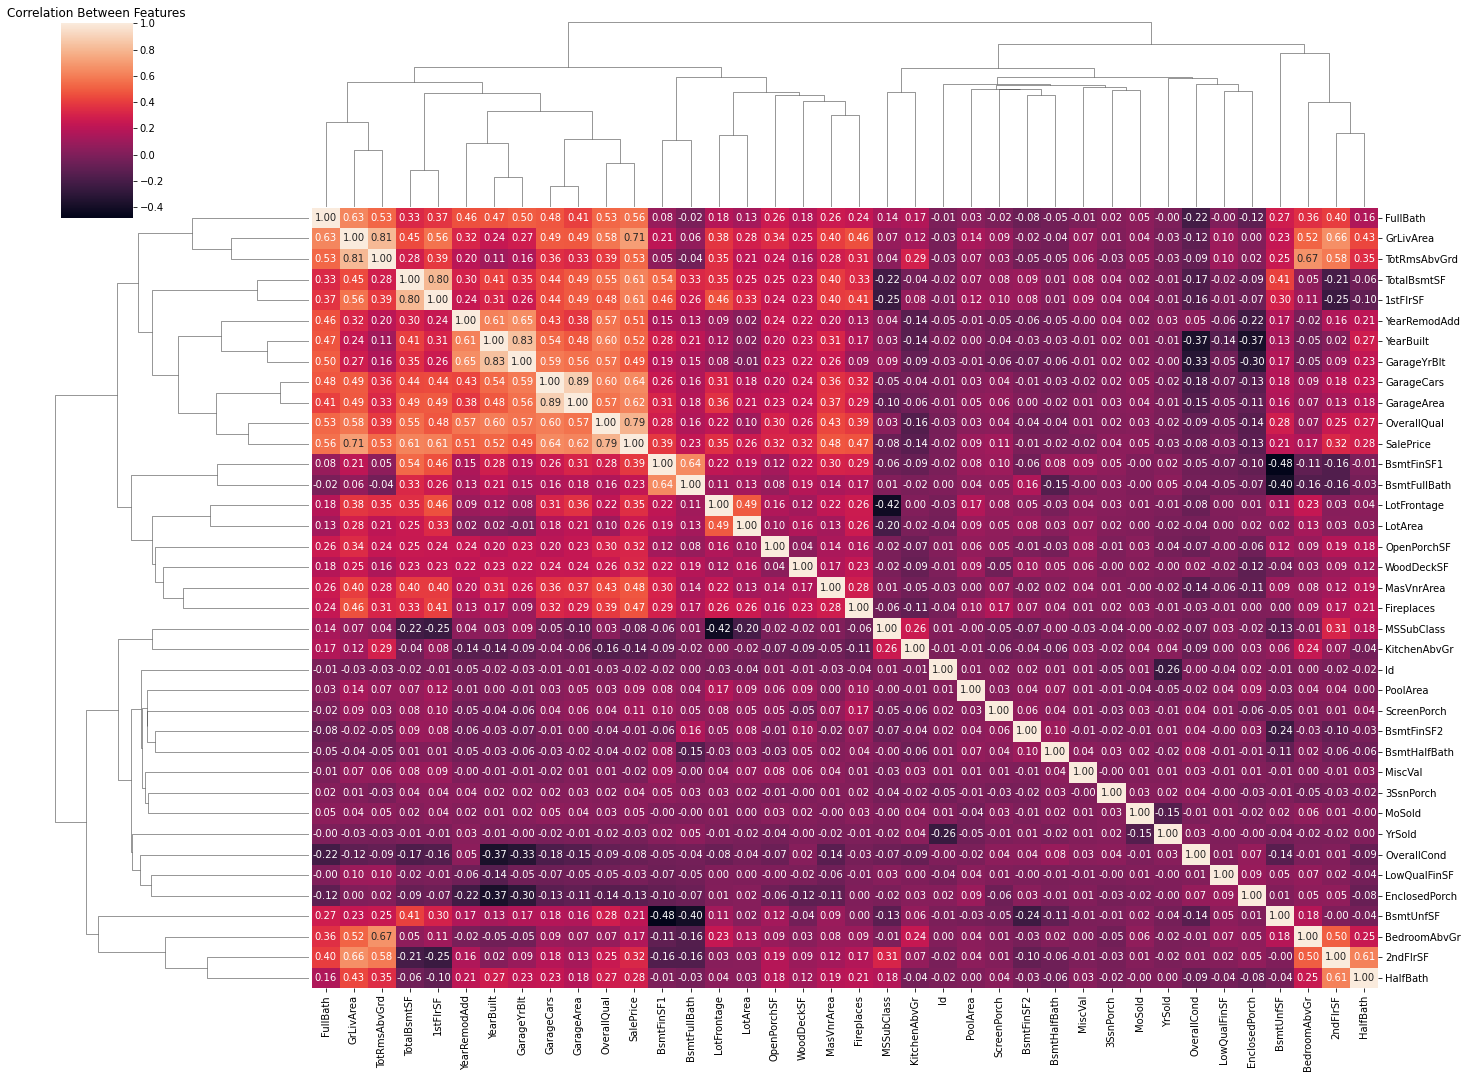

In [13]:
# tüm değişkenler korelasyon
corr_matrix = df.corr()
sns.clustermap(corr_matrix, annot = True, figsize=(20,15), fmt=".2f" )
plt.title("Correlation Between Features")
plt.show()

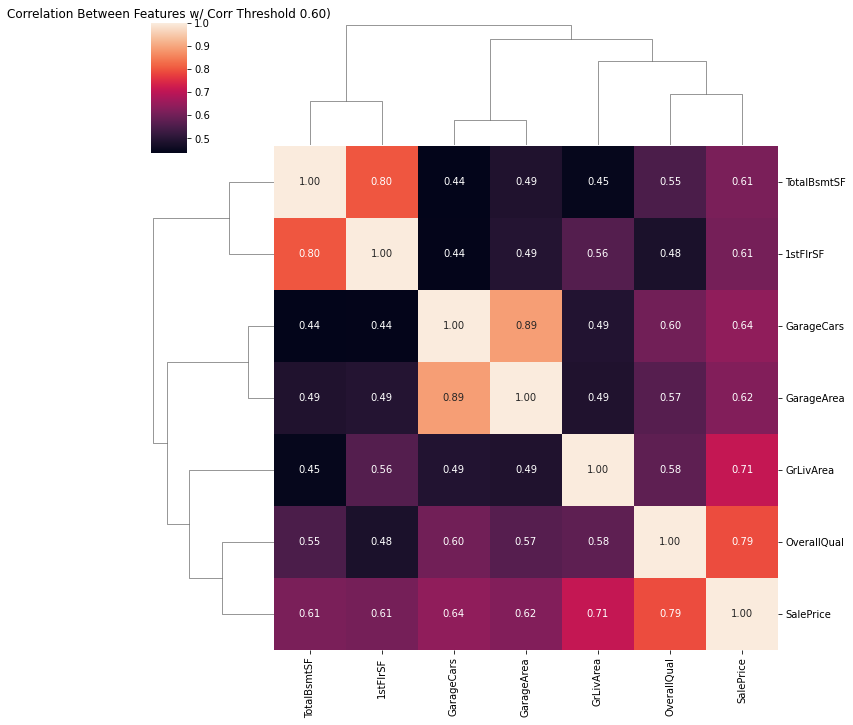

In [14]:
threshold = 0.60
filter = np.abs(corr_matrix["SalePrice"]) > threshold
corr_features = corr_matrix.columns[filter].tolist()
sns.clustermap(df[corr_features].corr(), annot = True, fmt = ".2f")
plt.title("Correlation Between Features w/ Corr Threshold 0.60)")
plt.show()

In [15]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.60):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
    return drop_list

high_correlated_cols(df)

['YearRemodAdd',
 '1stFlrSF',
 'GrLivArea',
 'BsmtFullBath',
 'FullBath',
 'HalfBath',
 'TotRmsAbvGrd',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'SalePrice']

In [16]:
# FEATURE ENGINEERING

df["SqFtPerRoom"] = df["GrLivArea"] / (df["TotRmsAbvGrd"] +
                                                       df["FullBath"] +
                                                       df["HalfBath"] +
                                                       df["KitchenAbvGr"])

df['Total_Home_Quality'] = df['OverallQual'] + df['OverallCond']

df['Total_Bathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) +
                                 df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))

df["HighQualSF"] = df["1stFlrSF"] + df["2ndFlrSF"]

In [17]:
# Converting non-numeric predictors stored as numbers into string

df['MSSubClass'] = df['MSSubClass'].apply(str)
df['YrSold'] = df['YrSold'].apply(str)
df['MoSold'] = df['MoSold'].apply(str)

In [18]:
# RARE ENCODING
def rare_encoder(dataframe, rare_perc, cat_cols):
    rare_columns = [col for col in cat_cols if (dataframe[col].value_counts() / len(dataframe) < 0.01).sum()>1]
    for col in rare_columns:
        tmp = dataframe[col].value_counts() / len(dataframe)
        rare_labels = tmp[tmp < rare_perc].index
        dataframe[col] = np.where(dataframe[col].isin(rare_labels), 'Rare', dataframe[col])

    return dataframe

def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

rare_analyser(df, "SalePrice", cat_cols)

MSZoning : 5
         COUNT     RATIO    TARGET_MEAN
C (all)     25  0.008565   74528.000000
FV         139  0.047619  214014.061538
RH          26  0.008907  131558.375000
RL        2265  0.775951  191004.994787
RM         460  0.157588  126316.830275


Street : 2
      COUNT     RATIO    TARGET_MEAN
Grvl     12  0.004111  130190.500000
Pave   2907  0.995889  181130.538514


Alley : 2
      COUNT     RATIO    TARGET_MEAN
Grvl    120  0.041110  122219.080000
Pave     78  0.026721  168000.585366


LotShape : 4
     COUNT     RATIO    TARGET_MEAN
IR1    968  0.331620  206101.665289
IR2     76  0.026036  239833.365854
IR3     16  0.005481  216036.500000
Reg   1859  0.636862  164754.818378


LandContour : 4
     COUNT     RATIO    TARGET_MEAN
Bnk    117  0.040082  143104.079365
HLS    120  0.041110  231533.940000
Low     60  0.020555  203661.111111
Lvl   2622  0.898253  180183.746758


Utilities : 2
        COUNT     RATIO   TARGET_MEAN
AllPub   2916  0.998972  180950.95682
NoSeWa      1  

In [19]:
df = rare_encoder(df, 0.01, cat_cols)

drop_list = ["Street", "SaleCondition", "Functional", "Condition2", "Utilities", "SaleType", "MiscVal",
             "Alley", "LandSlope", "PoolQC", "MiscFeature", "Electrical", "Fence", "RoofStyle", "RoofMatl",
             "FireplaceQu"]

cat_cols = [col for col in cat_cols if col not in drop_list]

for col in drop_list:
    df.drop(col, axis=1, inplace=True)

rare_analyser(df, "SalePrice", cat_cols)

MSZoning : 4
      COUNT     RATIO    TARGET_MEAN
FV      139  0.047619  214014.061538
RL     2265  0.775951  191004.994787
RM      460  0.157588  126316.830275
Rare     51  0.017472  109623.615385


LotShape : 4
     COUNT     RATIO    TARGET_MEAN
IR1    968  0.331620  206101.665289
IR2     76  0.026036  239833.365854
IR3     16  0.005481  216036.500000
Reg   1859  0.636862  164754.818378


LandContour : 4
     COUNT     RATIO    TARGET_MEAN
Bnk    117  0.040082  143104.079365
HLS    120  0.041110  231533.940000
Low     60  0.020555  203661.111111
Lvl   2622  0.898253  180183.746758


LotConfig : 5
         COUNT     RATIO    TARGET_MEAN
Corner     511  0.175060  181623.425856
CulDSac    176  0.060295  223854.617021
FR2         85  0.029120  177934.574468
FR3         14  0.004796  208475.000000
Inside    2133  0.730730  176938.047529


Condition1 : 6
        COUNT     RATIO    TARGET_MEAN
Artery     92  0.031518  135091.666667
Feedr     164  0.056184  142475.481481
Norm     2511  0.86

In [20]:
useless_cols = [col for col in cat_cols if df[col].nunique() == 1 or
                (df[col].nunique() == 2 and (df[col].value_counts() / len(df) <= 0.01).any(axis=None))]

cat_cols = [col for col in cat_cols if col not in useless_cols]


for col in useless_cols:
    df.drop(col, axis=1, inplace=True)

rare_analyser(df, "SalePrice", cat_cols)

MSZoning : 4
      COUNT     RATIO    TARGET_MEAN
FV      139  0.047619  214014.061538
RL     2265  0.775951  191004.994787
RM      460  0.157588  126316.830275
Rare     51  0.017472  109623.615385


LotShape : 4
     COUNT     RATIO    TARGET_MEAN
IR1    968  0.331620  206101.665289
IR2     76  0.026036  239833.365854
IR3     16  0.005481  216036.500000
Reg   1859  0.636862  164754.818378


LandContour : 4
     COUNT     RATIO    TARGET_MEAN
Bnk    117  0.040082  143104.079365
HLS    120  0.041110  231533.940000
Low     60  0.020555  203661.111111
Lvl   2622  0.898253  180183.746758


LotConfig : 5
         COUNT     RATIO    TARGET_MEAN
Corner     511  0.175060  181623.425856
CulDSac    176  0.060295  223854.617021
FR2         85  0.029120  177934.574468
FR3         14  0.004796  208475.000000
Inside    2133  0.730730  176938.047529


Condition1 : 6
        COUNT     RATIO    TARGET_MEAN
Artery     92  0.031518  135091.666667
Feedr     164  0.056184  142475.481481
Norm     2511  0.86

In [21]:
# Label Encoding & ONE-HOT ENCODING

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

cat_cols, num_cols, cat_but_car = grab_col_names(df)
cat_cols = cat_cols + cat_but_car
df = one_hot_encoder(df, cat_cols, drop_first=True)

check_df(df)

Observations: 2919
Variables: 69
cat_cols: 39
num_cols: 29
cat_but_car: 1
num_but_cat: 3
##################### Shape #####################
(2919, 215)
##################### Types #####################
Id                        int64
LotFrontage             float64
LotArea                   int64
OverallQual               int64
YearBuilt                 int64
                         ...   
Neighborhood_SawyerW      uint8
Neighborhood_Somerst      uint8
Neighborhood_StoneBr      uint8
Neighborhood_Timber       uint8
Neighborhood_Veenker      uint8
Length: 215, dtype: object
##################### Head #####################
   Id  LotFrontage  LotArea  OverallQual  YearBuilt  YearRemodAdd  MasVnrArea  \
0   1         65.0     8450            7       2003          2003       196.0   
1   2         80.0     9600            6       1976          1976         0.0   
2   3         68.0    11250            7       2001          2002       162.0   
3   4         60.0     9550            7       

In [22]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

rare_analyser(df, "SalePrice", cat_cols)

useless_cols_new = [col for col in cat_cols if (df[col].value_counts() / len(df) <= 0.01).any(axis=None)]

df[useless_cols_new].head()

for col in useless_cols_new:
    cat_summary(df, col)

rare_analyser(df, "SalePrice", useless_cols_new)

Observations: 2919
Variables: 215
cat_cols: 186
num_cols: 29
cat_but_car: 0
num_but_cat: 186
MSSubClass_150 : 2
   COUNT     RATIO   TARGET_MEAN
0   2918  0.999657  180921.19589
1      1  0.000343           NaN


MSSubClass_160 : 2
   COUNT     RATIO    TARGET_MEAN
0   2791  0.956149  182827.602720
1    128  0.043851  138647.380952


MSSubClass_180 : 2
   COUNT     RATIO    TARGET_MEAN
0   2902  0.994176  181463.411034
1     17  0.005824  102300.000000


MSSubClass_190 : 2
   COUNT     RATIO    TARGET_MEAN
0   2858  0.979102  181997.584615
1     61  0.020898  129613.333333


MSSubClass_20 : 2
   COUNT     RATIO    TARGET_MEAN
0   1840  0.630353  178424.726190
1   1079  0.369647  185224.811567


MSSubClass_30 : 2
   COUNT     RATIO    TARGET_MEAN
0   2780  0.952381  185142.124371
1    139  0.047619   95829.724638


MSSubClass_40 : 2
   COUNT     RATIO    TARGET_MEAN
0   2913  0.997945  180989.317308
1      6  0.002055  156125.000000


MSSubClass_45 : 2
   COUNT     RATIO    TARGET_MEAN


In [23]:
# Missing Values

def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

missing_values_table(df)

                 n_miss  ratio
SalePrice          1459  49.98
LotFrontage         486  16.65
GarageYrBlt         159   5.45
MasVnrArea           23   0.79
Total_Bathrooms       2   0.07
BsmtFinSF1            1   0.03
BsmtFinSF2            1   0.03
BsmtUnfSF             1   0.03
TotalBsmtSF           1   0.03
GarageArea            1   0.03


In [24]:
test.shape

(1459, 80)

In [25]:
missing_values_table(train)

              n_miss  ratio
PoolQC          1453  99.52
MiscFeature     1406  96.30
Alley           1369  93.77
Fence           1179  80.75
FireplaceQu      690  47.26
LotFrontage      259  17.74
GarageType        81   5.55
GarageYrBlt       81   5.55
GarageFinish      81   5.55
GarageQual        81   5.55
GarageCond        81   5.55
BsmtExposure      38   2.60
BsmtFinType2      38   2.60
BsmtFinType1      37   2.53
BsmtCond          37   2.53
BsmtQual          37   2.53
MasVnrArea         8   0.55
MasVnrType         8   0.55
Electrical         1   0.07


In [26]:
na_cols = [col for col in df.columns if df[col].isnull().sum() > 0 and "SalePrice" not in col]

df[na_cols] = df[na_cols].apply(lambda x: x.fillna(x.median()), axis=0)

In [27]:
# Outliers
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

for col in num_cols:
    print(col, check_outlier(df, col, q1=0.01, q3=0.99))

Id False
LotFrontage True
LotArea True
OverallQual False
YearBuilt False
YearRemodAdd False
MasVnrArea False
BsmtFinSF1 True
BsmtFinSF2 False
BsmtUnfSF False
TotalBsmtSF True
1stFlrSF True
2ndFlrSF False
LowQualFinSF True
GrLivArea False
TotRmsAbvGrd False
GarageYrBlt True
GarageArea False
WoodDeckSF True
OpenPorchSF True
EnclosedPorch True
3SsnPorch True
ScreenPorch False
PoolArea True
SalePrice False
SqFtPerRoom False
Total_Home_Quality False
Total_Bathrooms False
HighQualSF False


In [28]:
# Model

df.shape

(2919, 215)

In [29]:
train_df = df[df['SalePrice'].notnull()]
test_df = df[df['SalePrice'].isnull()].drop("SalePrice", axis=1)

train_df.shape

(1460, 215)

In [30]:
test_df.shape

(1459, 214)

In [31]:
y = np.log1p(train_df['SalePrice'])
X = train_df.drop(["Id", "SalePrice"], axis=1)

X.shape

(1460, 213)

In [32]:
# Base Models
##################

models = [('LR', LinearRegression()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          ('GBM', GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor(objective='reg:squarederror')),
          ("LightGBM", LGBMRegressor())]

for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=3, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name}) ")

RMSE: 0.1488 (LR) 
RMSE: 0.2161 (CART) 
RMSE: 0.1464 (RF) 
RMSE: 0.1349 (GBM) 
RMSE: 0.1452 (XGBoost) 
RMSE: 0.1388 (LightGBM) 


**Hyperparameter Optimization**

In [33]:
lgbm_model = LGBMRegressor(random_state=46)

In [34]:
# modelleme öncesi hata:
rmse = np.mean(np.sqrt(-cross_val_score(lgbm_model,
                                        X, y, cv=10, scoring="neg_mean_squared_error")))
rmse

0.1305858947475748

In [35]:
lgbm_params = {"learning_rate": [0.01, 0.005],
               "n_estimators": [15000, 20000],
               "colsample_bytree": [0.5, 0.3]}

In [36]:
lgbm_gs_best = GridSearchCV(lgbm_model,
                            lgbm_params,
                            cv=10,
                            n_jobs=-1,
                            verbose=False).fit(X, y)

final_model = lgbm_model.set_params(**lgbm_gs_best.best_params_).fit(X, y)

rmse = np.mean(np.sqrt(-cross_val_score(final_model, X, y, cv=10, scoring="neg_mean_squared_error")))
print(rmse)

0.12328413251903


In [37]:
#hiperparametrelerin default kendi değeriyle rmse 0.1305858 idi.
#optimizasyonlarla 0.12328 e indirdik

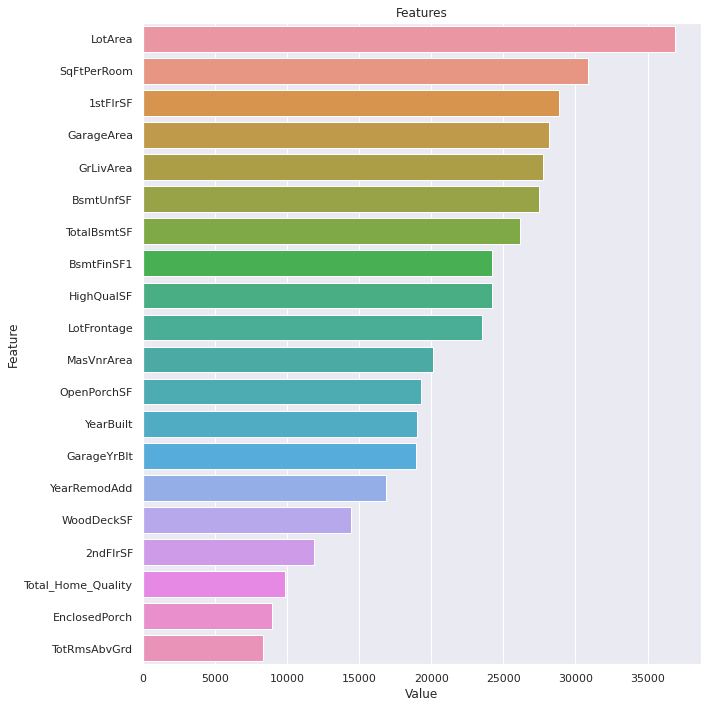

In [38]:
# Feature Selection

def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(final_model, X, 20)

In [39]:
X.shape

(1460, 213)

In [40]:
feature_imp = pd.DataFrame({'Value': final_model.feature_importances_, 'Feature': X.columns})

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

num_summary(feature_imp, "Value", True)

count      213.000000
mean      2816.901408
std       6503.181212
min          0.000000
5%           0.000000
10%          0.000000
20%         56.000000
30%        266.400000
40%        534.000000
50%        711.000000
60%       1018.000000
70%       1358.000000
80%       1859.400000
90%       6904.000000
95%      19625.800000
99%      28797.520000
max      36877.000000
Name: Value, dtype: float64


In [41]:
feature_imp[feature_imp["Value"] > 0].shape

feature_imp[feature_imp["Value"] < 1].shape

zero_imp_cols = feature_imp[feature_imp["Value"] < 1]["Feature"].values

selected_cols = [col for col in X.columns if col not in zero_imp_cols]

In [42]:
# Hyperparameter Optimization with Selected Features

lgbm_model = LGBMRegressor(random_state=46)

lgbm_params = {"learning_rate": [0.01, 0.005],
               "n_estimators": [15000, 20000],
               "colsample_bytree": [0.5, 0.3]}

lgbm_gs_best = GridSearchCV(lgbm_model,
                            lgbm_params,
                            cv=10,
                            n_jobs=-1,
                            verbose=True).fit(X[selected_cols], y)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 17.2min finished


In [43]:
y = np.log1p(train_df['SalePrice'])
X = train_df.drop(["Id", "SalePrice"], axis=1)

final_model = lgbm_model.set_params(**lgbm_gs_best.best_params_).fit(X[selected_cols], y)

rmse = np.mean(np.sqrt(-cross_val_score(final_model, X[selected_cols], y, cv=10, scoring="neg_mean_squared_error")))
print(rmse)

0.12326648233913536


In [44]:
# SONUCLARIN YUKLENMESI
#######################################

submission_df = pd.DataFrame()

submission_df['Id'] = test_df["Id"].astype("Int32")
submission_df.head()

,Id
1460,1461
1461,1462
1462,1463
1463,1464
1464,1465


In [45]:
y_pred_sub = final_model.predict(test_df[selected_cols])
test_df.head()

,Id,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
1460,1461,80.0,11622,5,1961,1961,0.0,468.0,144.0,270.0,...,0,0,0,0,0,0,0,0,0,0
1461,1462,81.0,14267,6,1958,1958,108.0,923.0,0.0,406.0,...,0,0,0,0,0,0,0,0,0,0
1462,1463,74.0,13830,5,1997,1998,0.0,791.0,0.0,137.0,...,0,0,0,0,0,0,0,0,0,0
1463,1464,78.0,9978,6,1998,1998,20.0,602.0,0.0,324.0,...,0,0,0,0,0,0,0,0,0,0
1464,1465,43.0,5005,8,1992,1992,0.0,263.0,0.0,1017.0,...,0,0,0,0,0,0,0,1,0,0


In [46]:
y_pred_sub = np.expm1(y_pred_sub)

submission_df['SalePrice'] = y_pred_sub

submission_df.to_csv('submission.csv', index=False)

In [47]:
submission_df

,Id,SalePrice
1460,1461,114758.275916
1461,1462,161012.281825
1462,1463,180635.222089
1463,1464,191271.916541
1464,1465,185526.909181
...,...,...
2914,2915,85933.800552
2915,2916,82369.355020
2916,2917,167385.553185
2917,2918,109579.803088
